먼저 이미지를 배열화 시켜주어야 한다.

그리고 여기 이미지에서 훈련 데이터, 테스트 데이터(사실상 검증 데이터)로 나눠준다.

이후 numpy 형태로 저장.

In [17]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './ipynb/data3/train'
categories = ['0', '1']
np_classes = len(categories)

image_w = 128
image_h = 128


pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/image_data.npy", xy)

0  :  ./ipynb/data3/train/0\Tomato_healthy (1).JPG
0  :  ./ipynb/data3/train/0\Tomato_healthy (1269).JPG
0  :  ./ipynb/data3/train/0\Tomato_healthy (1539).JPG
0  :  ./ipynb/data3/train/0\Tomato_healthy (377).JPG
0  :  ./ipynb/data3/train/0\Tomato_healthy (647).JPG
0  :  ./ipynb/data3/train/0\Tomato_healthy (917).JPG
1  :  ./ipynb/data3/train/1\Tomato_Septoria (1).JPG
1  :  ./ipynb/data3/train/1\Tomato_Septoria (397).JPG
1  :  ./ipynb/data3/train/1\Tomato_Septoria (667).JPG
1  :  ./ipynb/data3/train/1\Tomato_Septoria (937).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (1206).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (1477).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (1747).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (2016).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (2287).JPG
1  :  ./ipynb/data3/train/1\Tomato_Spider (2557).JPG


이제 훈련을 시작한다. 저장한 numpy 값을 가지고 와서 컨볼루션 망을 구축한다.

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as K

X_train, X_test, y_train, y_test = np.load('./numpy_data/image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(3965, 128, 128, 3)
3965
[1429 2536]
[162 279]


In [ ]:
image_w = 128
image_h = 128
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

import tensorflow.compat.v1 as tf

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/plant.model"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)       

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Epoch 1/100
53/53 [==============================] - 81s 1s/step - loss: 0.6708 - accuracy: 0.6278 - val_loss: 0.5132 - val_accuracy: 0.6924

Epoch 00001: val_loss improved from inf to 0.51317, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 2/100
53/53 [==============================] - 70s 1s/step - loss: 0.4069 - accuracy: 0.7992 - val_loss: 0.2906 - val_accuracy: 0.8555

Epoch 00002: val_loss improved from 0.51317 to 0.29061, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 3/100
53/53 [==============================] - 72s 1s/step - loss: 0.2444 - accuracy: 0.9009 - val_loss: 0.1344 - val_accuracy: 0.9630

Epoch 00003: val_loss improved from 0.29061 to 0.13437, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 4/100
53/53 [==============================] - 71s 1s/step - loss: 0.1411 - accuracy: 0.9543 - val_loss: 0.093

In [12]:
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

1/1 [==============================] - 0s 98ms/step - loss: 1.1628 - accuracy: 0.0000e+00
정확도 : 0.00 


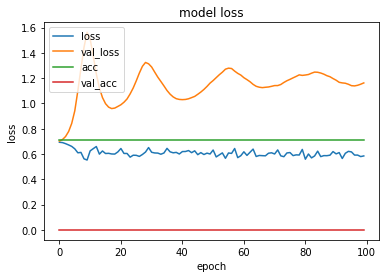

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()